## Recommendation Engine

In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_json('tops_fashion.json')

In [3]:
print('Number of data points:', data.shape[0])
print('Number of features/variables:', data.shape[1])
data.head()

Number of data points: 183138
Number of features/variables: 19


,sku,asin,product_type_name,formatted_price,author,color,brand,publisher,availability,reviews,large_image_url,availability_type,small_image_url,editorial_review,title,model,medium_image_url,manufacturer,editorial_reivew
0,None,B016I2TS4W,SHIRT,None,None,None,FNC7C,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Women's O Nec...,Minions Como Superheroes Ironman Long Sleeve R...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
1,None,B01N49AI08,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Izo Tunic,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
2,None,B01JDPCOHO,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Won Top,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
3,None,B01N19U5H5,SHIRT,None,None,None,Focal18,None,None,"[True, https://www.amazon.com/reviews/iframe?a...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,100% Brand New & Fashion<br> Quantity: 1 Piece...,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
4,None,B004GSI2OS,SHIRT,$26.26,None,Onyx Black/ Stone,FeatherLite,None,Usually ships in 6-10 business days,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,,Featherlite Ladies' Long Sleeve Stain Resistan...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN


In [4]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

In [5]:
data = data[['asin','brand','color','medium_image_url','product_type_name','title','formatted_price',]]

In [6]:
data.shape

(183138, 7)

In [7]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


#### Exploratory Data Analysis

In [8]:
for col in data.columns:
    print('##### Basic stats for feature:', col, '#####')
    print(data[col].describe())
    print(data[col].unique())
    product_type_count = Counter(list(data[col]))
    print(product_type_count.most_common(10))
    print()

##### Basic stats for feature: asin #####
count         183138
unique        183138
top       B016I2TS4W
freq               1
Name: asin, dtype: object
['B016I2TS4W' 'B01N49AI08' 'B01JDPCOHO' ... 'B075756PGC' 'B074L8FVTT'
 'B074FTYJQC']
[('B016I2TS4W', 1), ('B01N49AI08', 1), ('B01JDPCOHO', 1), ('B01N19U5H5', 1), ('B004GSI2OS', 1), ('B00TAEHGGS', 1), ('B012YX2ZPI', 1), ('B074GPTP3J', 1), ('B06Y2LCC5S', 1), ('B00T9W4E66', 1)]

##### Basic stats for feature: brand #####
count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object
['FNC7C' 'FIG Clothing' 'Focal18' ... 'Z' "Rain's Pan Jacket"
 'FFLMYUHULIU']
[('Zago', 223), ('XQS', 222), ('Yayun', 215), ('YUNY', 198), ('XiaoTianXin-women clothes', 193), ('Generic', 192), ('Boohoo', 190), ('Alion', 188), ('Abetteric', 187), ('TheMogan', 187)]

##### Basic stats for feature: color #####
count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object
[None 'Onyx Black/ Stone' 'Grape'

In [9]:
# delete data points with null price and null color values
data = data.loc[~data['formatted_price'].isnull()]
data = data.loc[~data['color'].isnull()]
print('Number of data points after deleting those that have null price or null color:', data.shape[0])

Number of data points after deleting those that have null price or null color: 28385


### Deleting duplicates

In [10]:
# find data points with duplicate titles
print(sum(data.duplicated('title')))

2325


Delete rows with title length shorter than 4

In [11]:
data = data[data['title'].apply(lambda x: 4<len(x.split()))]
print('After removing products with short titles, we have:', data.shape[0])

After removing products with short titles, we have: 27949


Sort data points in descending alphabetical order of title

In [12]:
data.sort_values('title', inplace=True, ascending=False)
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


Delete rows that have titles with only last 2 words being different

In [13]:
def stage1_dedupe(data):
    import itertools
    
    indices = []
    for i,row in data.iterrows():
        indices.append(i)
        
    stage1_dedupe_asins = []
    i = 0
    j = 0
    n = data.shape[0]
    while i < n and j < n:
        
        prev_i = i

        # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        i_words = data['title'].loc[indices[i]].split()

        # search for the similar products sequentially 
        j = i+1
        while j < n:

            # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
            j_words = data['title'].loc[indices[j]].split()

            # store the maximum length among the two titles at i and j
            length = max(len(i_words), len(j_words))

            # count is used to store the number of words that are matched in both strings
            count  = 0

            # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
            # example: a =['a', 'b', 'c', 'd']
            # b = ['a', 'b', 'd']
            # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
            for k in itertools.zip_longest(i_words,j_words): 
                if (k[0] == k[1]):
                    count += 1

            # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
            # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
            if (length - count) > 2: # number of words in which both sensences differ
                # if both strings are differ by more than 2 words we include the 1st string index
                stage1_dedupe_asins.append(data['asin'].loc[indices[i]])

                # if the comaprision is between i=n-2 and j=n-1 titles and they differ in more than 2 words we include both, since j will not get a chance to get included in future
                if j == n-1: stage1_dedupe_asins.append(data['asin'].loc[indices[j]])

                # start searching for similar apparrels from first mismatch index, ie j
                i = j
                break
            else:
                j += 1
        if prev_i == i:
            break
    
    data = data.loc[data['asin'].isin(stage1_dedupe_asins)]
    return data

In [14]:
data = stage1_dedupe(data)
print('Number of data points after stage 1 dedupe:', data.shape[0])

Number of data points after stage 1 dedupe: 17593


In [15]:
def stage2_dedupe(data):
    # This code snippet takes significant amount of time: O(n^2)
    import itertools

    indices = []
    for i,row in data.iterrows():
        indices.append(i)

    stage2_dedupe_asins = []
    while len(indices)!=0:
        i = indices.pop()
        stage2_dedupe_asins.append(data['asin'].loc[i])
        # consider the first apparrel's title
        i_words = data['title'].loc[i].split()
        # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        for j in indices:
            
            j_words = data['title'].loc[j].split()
            # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
            
            length = max(len(i_words),len(j_words))
            
            # count is used to store the number of words that are matched in both strings
            count  = 0

            # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
            # example: a =['a', 'b', 'c', 'd']
            # b = ['a', 'b', 'd']
            # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
            for k in itertools.zip_longest(i_words,j_words): 
                if (k[0]==k[1]):
                    count += 1

            # if the number of words in which both strings differ are < 3 , we are considering it as those two apparrels are same, hence we are ignoring them
            if (length - count) < 3:
                indices.remove(j)
    
    data = data.loc[data['asin'].isin(stage2_dedupe_asins)]
    return data

In [16]:
data = stage2_dedupe(data)
print('Number of data points after stage 2 dedupe:', data.shape[0])

KeyboardInterrupt: 

In [ ]:
data.to_pickle('./pickles/stg2_dedupe')

#### Text Preprocessing

In [ ]:
data = pd.read_pickle('./pickles/stg2_dedupe')

Remove stop words

In [ ]:
stopword_set = set(stopwords.words('english'))
print(stopword_set)

def remove_stopwords(txt):
    if type(txt) is int:
        return ''

    result = ''
    for word in txt.split():
        word = (''.join(e for e in word if e.isalnum()))
        word = word.lower()
        if not word in stopword_set:
            result += word + ' '
    
    return result

{'all', "i'll", 're', 'won', 'out', "they're", "we've", 'its', 'over', "isn't", 'wouldn', 'have', "haven't", 'here', 'above', "needn't", 'own', 'down', 'while', 'now', "he'll", 'whom', 'where', 'what', 'who', "doesn't", 'd', "aren't", 'once', 'ourselves', "didn't", 'up', 'y', 'some', 'myself', "he's", 'she', 'same', 'hers', 'they', 'do', 'few', 'after', 'does', 'into', 'hadn', 'by', 'very', "mustn't", "they'll", 'in', "she's", "should've", 'any', 'doing', 'these', 'from', 'how', 'through', 've', 'mightn', 'when', "don't", "they'd", "hasn't", 'them', 'during', "she'd", 'yourself', 'between', 'your', 'at', 'did', 'it', 'nor', 'o', 'but', 'my', "we'll", "you're", 'having', "we're", 'i', 'aren', 'isn', "it's", 'again', 'was', 'weren', 'yourselves', 'don', "shan't", 'be', 'those', "we'd", 'so', 'didn', 'should', 'as', "they've", 'been', 'were', "wouldn't", 'his', 'has', 'me', 'this', "i'm", "it'll", 'of', 'only', 'if', 'needn', "i'd", 'about', "weren't", 'can', 'shan', "that'll", 'no', "sho

In [ ]:
# could take 10+ seconds
for i in range(data.shape[0]):
    data.at[data.index[i], 'title'] = remove_stopwords(data.at[data.index[i], 'title'])

In [ ]:
data['title'].head()

61973     éclair womens printed thin strap blouse black ...
133820    xiaoming womens sleeveless loose long tshirts ...
81461     xiaoming womens white long sleeve single breas...
75995     xiaoming stripes tank patchbear sleeve anchor ...
151570    xiaoming sleeve sheer loose tassel kimono woma...
Name: title, dtype: object

In [ ]:
data.to_pickle('./pickles/no_stopwords')

Text based product similarity

In [ ]:
data = pd.read_pickle('./pickles/no_stopwords')

In [ ]:
# utility functions

In [ ]:
def show_img(url):
    res = requests.get(url)
    img = Image.open(BytesIO(res.content))
    plt.imshow(img)

In [ ]:
def plot_heatmap(keys, vals, labels, url, txt):
    # keys = list of words in recommended title
    # vals = vals[i] is freq of keys[i] in recommended title
    # labels
    #   if model is BoW, labels[i] = vals[i]
    #   if model is TF-IDF, labels[i] = tfidf(keys[i])
    #   if model is IDF-weighted BoW, labels[i] = idf(keys[i])
    # url = apparel's image url
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1])
    fig = plt.figure(figsize=(25,3))
    
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.array([vals]), annot=np.array([labels]))
    ax.set_xticklabels(keys)
    ax.set_title(txt)
    
    ax = plt.subplot(gs[1])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    show_img(url)
    # show_img(url, ax, fig)
    
    plt.show()

In [ ]:
def plot_heatmap_img(doc_id, vec1, vec2, url, txt, model):
    # doc_id = index of recommended item
    # vec1 = query item's title's vector (type: dict)
    # vec2 = recommended item's title's vector (type: dict)
    # url = recommended item's img url
    # txt = recommended item's title
    # model = Bag of Words OR TF-IDF
    
    intersection = set(vec1.keys()) & set(vec2.keys()) # only common words btw the 2 titles contribute to distance btw their vectors
    
    # zeroing all non relevant words to show the difference btw recommended item's title and query item's title well in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0
    
    keys = list(vec2.keys()) # for labelling heatmap, we collect all words in title of recommended item's title
    vals = [vec2[x] for x in vec2.keys()] # vals[i]=count of keys[i] if the word keys[i] was in the intersection, else vals[i]=0
    
    if model == 'bow':
        labels = vals
    elif model == 'tfidf':
        # tfidf_title_vectorizer.vocabulary_ contains all the words in the corpus
        # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (title represented by doc_id)
        labels=[]
        for x in vec2.keys():
            if x in tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    
    plot_heatmap(keys, vals, labels, url, txt)

In [ ]:
def txt_to_vec(txt):
    word_regex = re.compile(r'\w+')
    words = word_regex.findall(txt)
    return Counter(words)

In [ ]:
def show_recommendations(doc_id, content_a, content_b, url, model):
    txt1 = content_a
    txt2 = content_b
    
    vec1 = txt_to_vec(txt1) # vector 1 = dict{word11:#count, word12:#count, etc.}
    vec2 = txt_to_vec(txt2) # vector 2 = dict{word21:#count, word22:#count, etc.}
    
    plot_heatmap_img(doc_id, vec1, vec2, url, txt2, model)

Bag of Words (BoW) on product titles

In [ ]:
bow_title_vectorizer = CountVectorizer()
bow_title_features = bow_title_vectorizer.fit_transform(data['title'])
bow_title_features.get_shape()

(16462, 12698)

In [ ]:
def bow_model(doc_id, n):
    # doc_id = item's id in data corpus
    # n = required number of recommendations
    
    distances = pairwise_distances(bow_title_features, bow_title_features[doc_id]) # euclidian distances btw current title (bow_title_features[doc_id]) and all other titles (bow_title_features)
    chosen_indices = np.argsort(distances.flatten())[0:n]
    chosen_distances = np.sort(distances.flatten())[0:n]
    
    for i in range(len(chosen_indices)):
        first_row_idx = data.index[chosen_indices[0]]
        row_idx = data.index[chosen_indices[i]]
        
        show_recommendations(chosen_indices[i], data.at[first_row_idx, 'title'],  data.at[row_idx, 'title'], data.at[row_idx, 'medium_image_url'], 'bow')
        print('ASIN :', data.at[row_idx, 'asin'])
        print ('Brand:', data.at[row_idx, 'brand'])
        print ('Title:', data.at[row_idx, 'title'])
        print ('Euclidean similarity with the queried item:', chosen_distances[i])

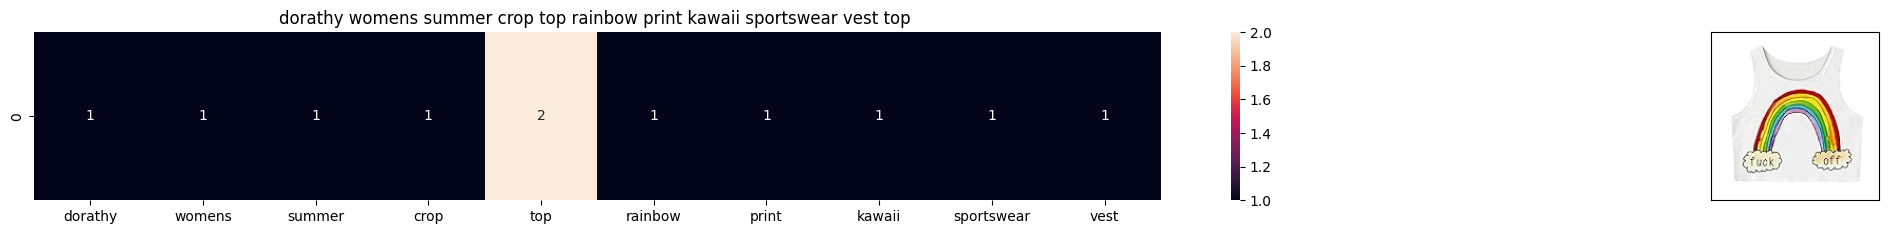

ASIN : B01HDKPU04
Brand: Dorathy
Title: dorathy womens summer crop top rainbow print kawaii sportswear vest top 
Euclidean similarity with the queried item: 0.0


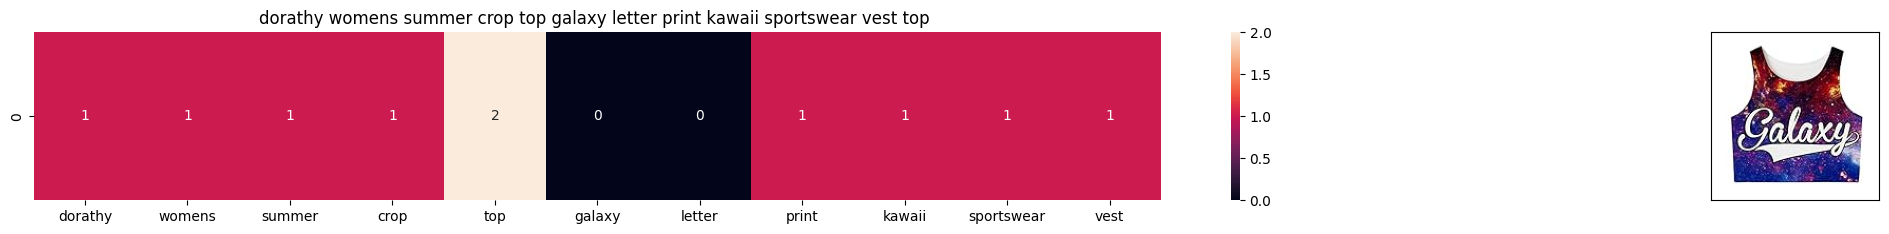

ASIN : B01HDKPKWC
Brand: Dorathy
Title: dorathy womens summer crop top galaxy letter print kawaii sportswear vest top 
Euclidean similarity with the queried item: 1.7320508075688772


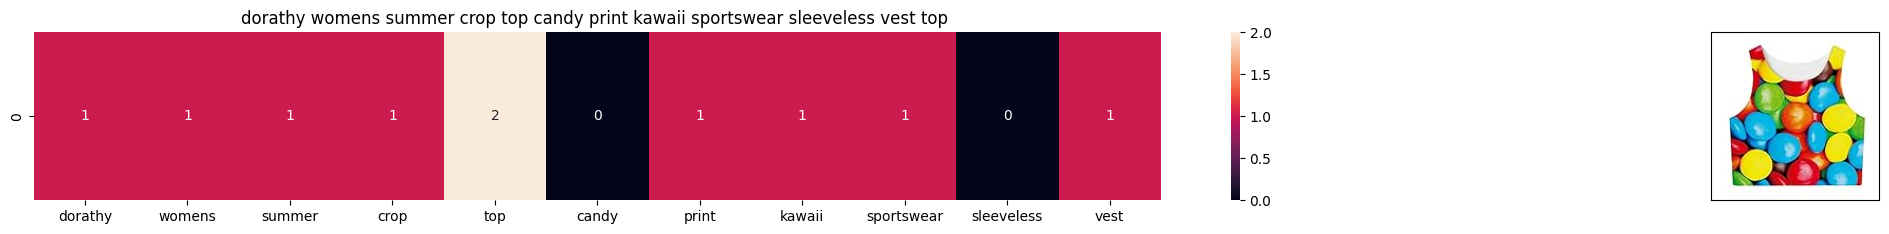

ASIN : B01HDKQ5IU
Brand: Dorathy
Title: dorathy womens summer crop top candy print kawaii sportswear sleeveless vest top 
Euclidean similarity with the queried item: 1.7320508075688772


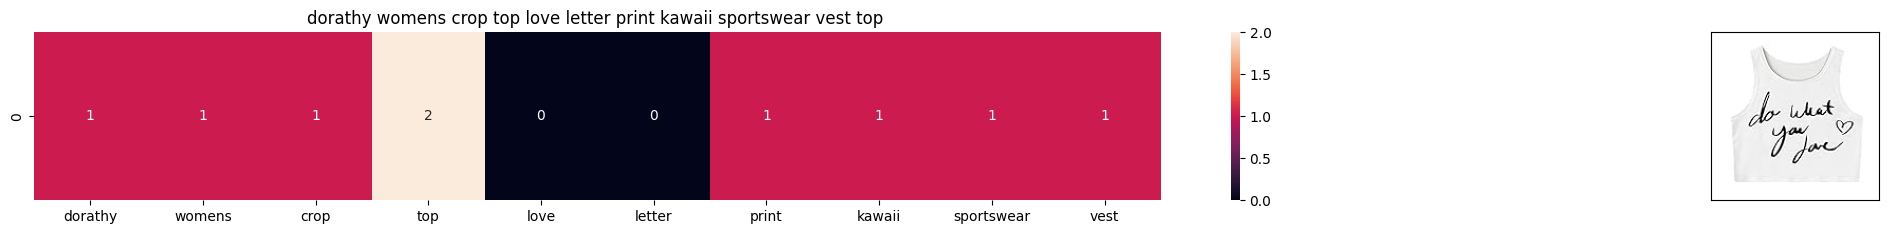

ASIN : B01HDKPJ2I
Brand: Dorathy
Title: dorathy womens crop top love letter print kawaii sportswear vest top 
Euclidean similarity with the queried item: 2.0


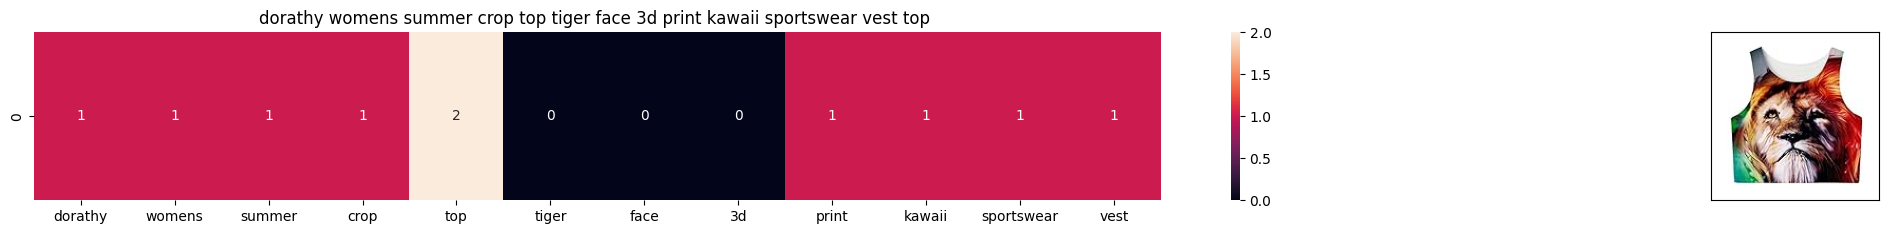

ASIN : B01HDKPMVQ
Brand: Dorathy
Title: dorathy womens summer crop top tiger face 3d print kawaii sportswear vest top 
Euclidean similarity with the queried item: 2.0


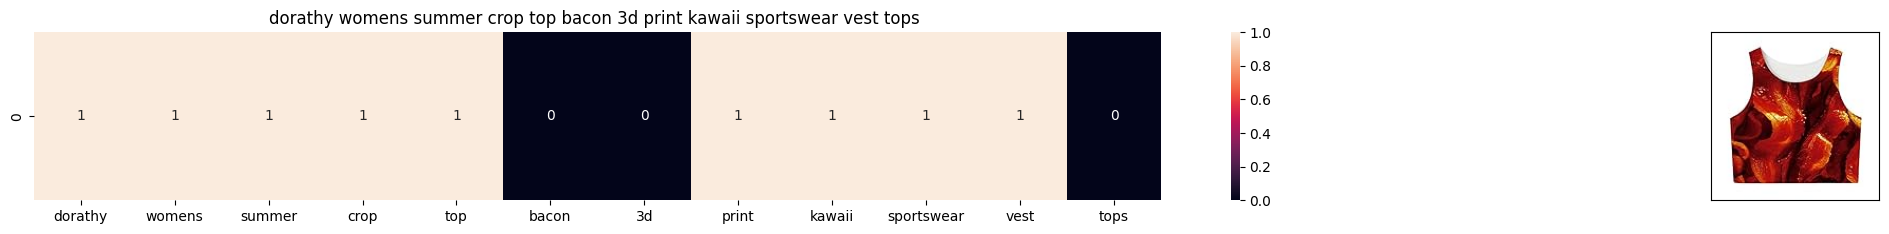

ASIN : B01HDKQ936
Brand: Dorathy
Title: dorathy womens summer crop top bacon 3d print kawaii sportswear vest tops 
Euclidean similarity with the queried item: 2.23606797749979


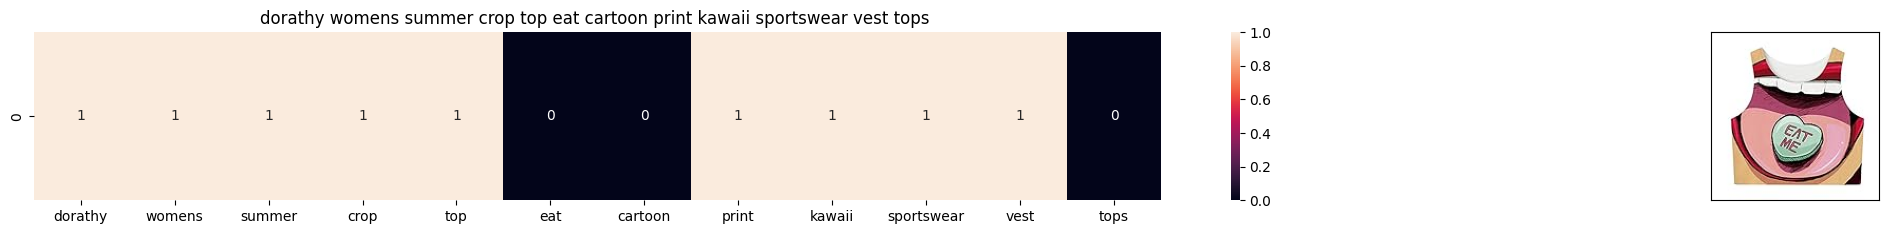

ASIN : B01HDKQ79M
Brand: Dorathy
Title: dorathy womens summer crop top eat cartoon print kawaii sportswear vest tops 
Euclidean similarity with the queried item: 2.23606797749979


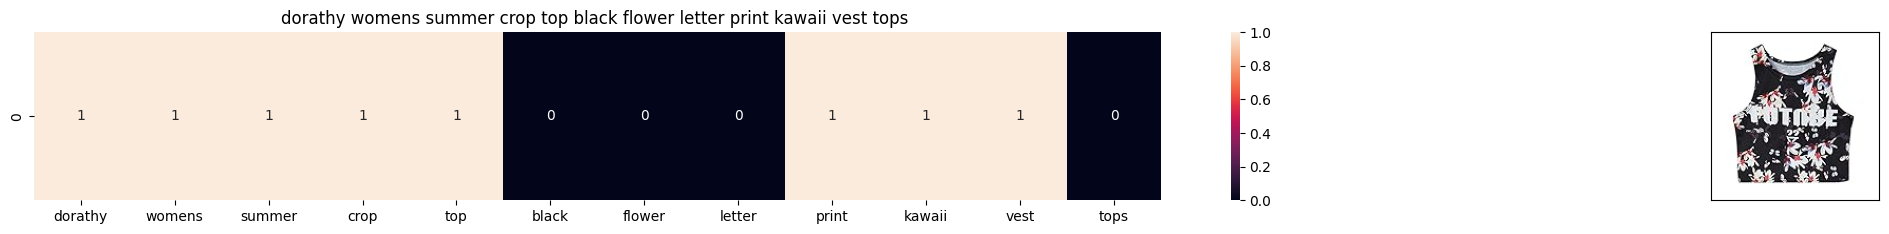

ASIN : B01HEMRFOU
Brand: Dorathy
Title: dorathy womens summer crop top black flower letter print kawaii vest tops 
Euclidean similarity with the queried item: 2.6457513110645907


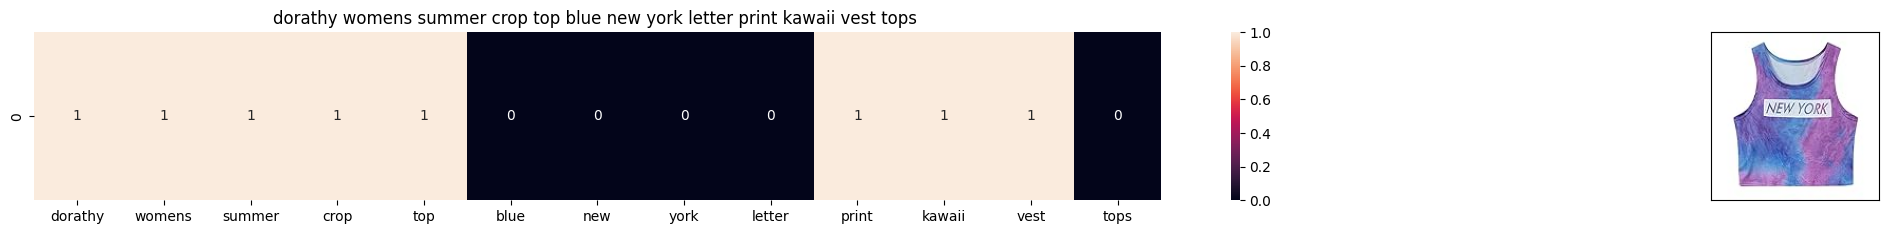

ASIN : B01HEMRL4Y
Brand: Dorathy
Title: dorathy womens summer crop top blue new york letter print kawaii vest tops 
Euclidean similarity with the queried item: 2.8284271247461903


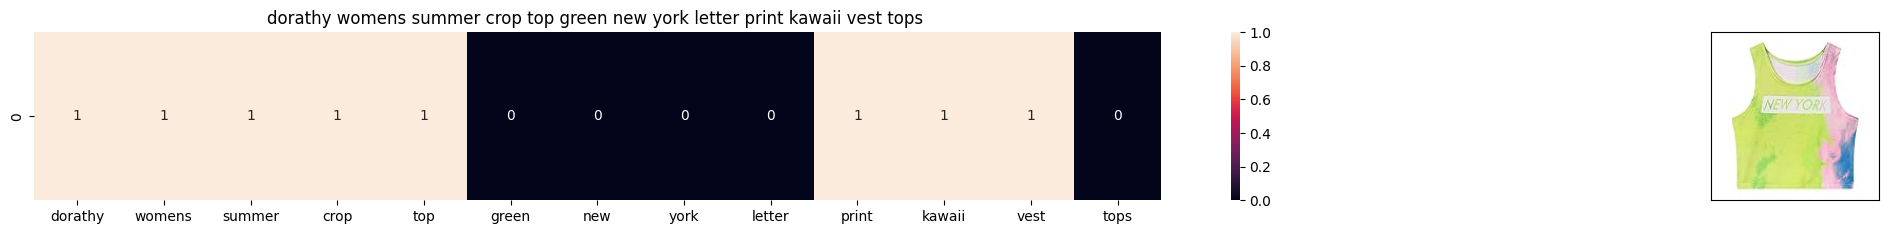

ASIN : B01HEMRIME
Brand: Dorathy
Title: dorathy womens summer crop top green new york letter print kawaii vest tops 
Euclidean similarity with the queried item: 2.8284271247461903


In [ ]:
bow_model(12565, 10)

TF-IDF on product title

In [ ]:
tfidf_title_vectorizer = TfidfVectorizer(min_df=0.0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

In [ ]:
def tfidf_model(doc_id, n):
    # doc_id = item's id in data corpus
    # n = required number of recommendations
    
    # distances = cosine_similarity(tfidf_title_features, tfidf_title_features[doc_id])
    distances = pairwise_distances(tfidf_title_features, tfidf_title_features[doc_id])
    chosen_indices = np.argsort(distances.flatten())[0:n]
    chosen_distances = np.sort(distances.flatten())[0:n]
    
    for i in range(len(chosen_indices)):
        first_row_idx = data.index[chosen_indices[0]]
        row_idx = data.index[chosen_indices[i]]
        
        show_recommendations(chosen_indices[i], data.at[first_row_idx, 'title'], data.at[row_idx, 'title'], data.at[row_idx, 'medium_image_url'], 'tfidf')
        print('ASIN :', data.at[row_idx, 'asin'])
        print ('Brand:', data.at[row_idx, 'brand'])
        print ('Title:', data.at[row_idx, 'title'])
        print ('Cosine similarity with the queried item:', chosen_distances[i])

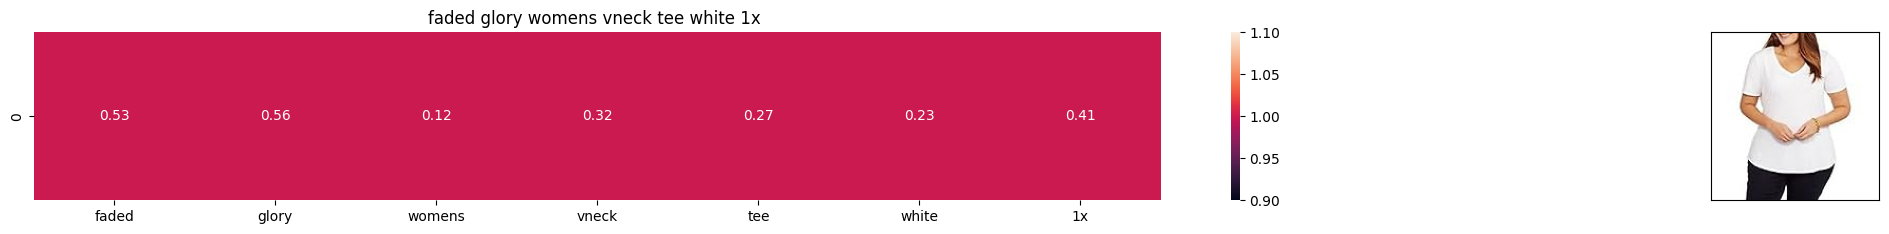

ASIN : B06XT63P1X
Brand: Faded Glory
Title: faded glory womens vneck tee white 1x 
Cosine similarity with the queried item: 0.0


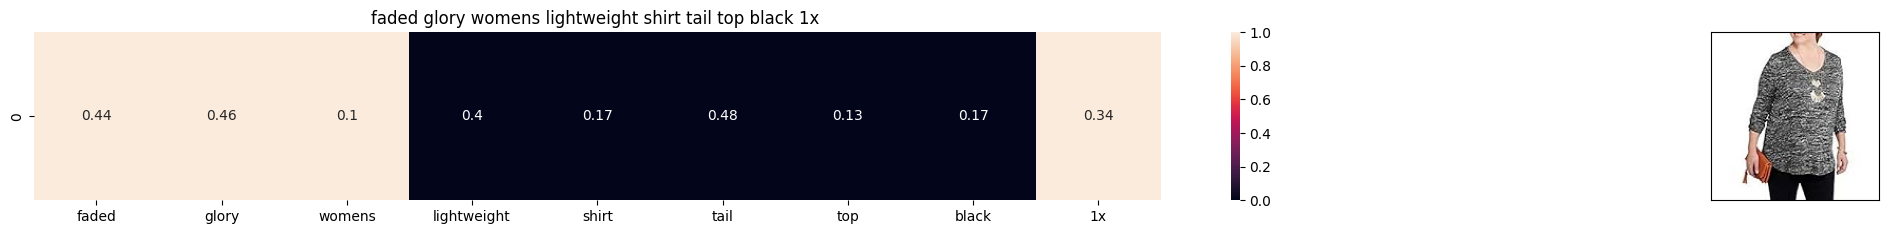

ASIN : B06XKQCBJD
Brand: Faded Glory
Title: faded glory womens lightweight shirt tail top black 1x 
Cosine similarity with the queried item: 0.8433978343638387


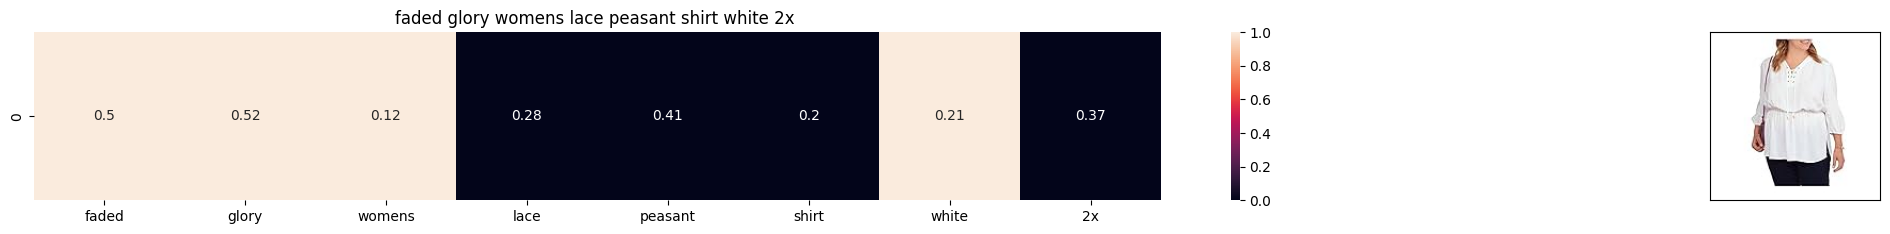

ASIN : B01MR26MXN
Brand: Faded Glory
Title: faded glory womens lace peasant shirt white 2x 
Cosine similarity with the queried item: 0.8731350129257127


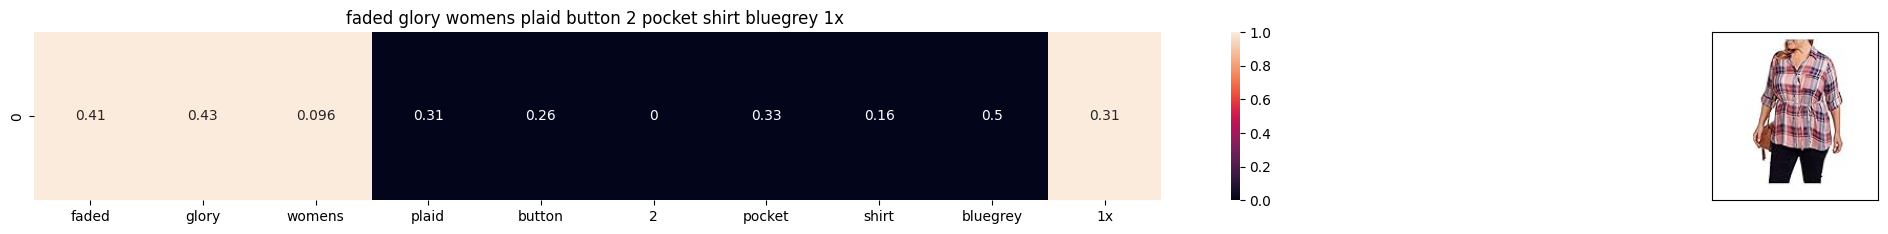

ASIN : B01NCO06S0
Brand: Faded Glory
Title: faded glory womens plaid button 2 pocket shirt bluegrey 1x 
Cosine similarity with the queried item: 0.9004454922509689


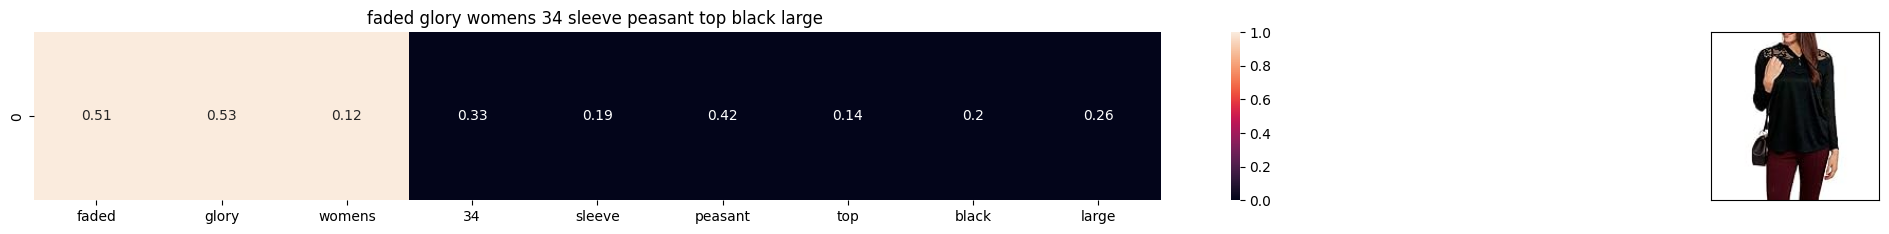

ASIN : B06XXHYBL6
Brand: Faded Glory
Title: faded glory womens 34 sleeve peasant top black large 
Cosine similarity with the queried item: 0.9150999733281475


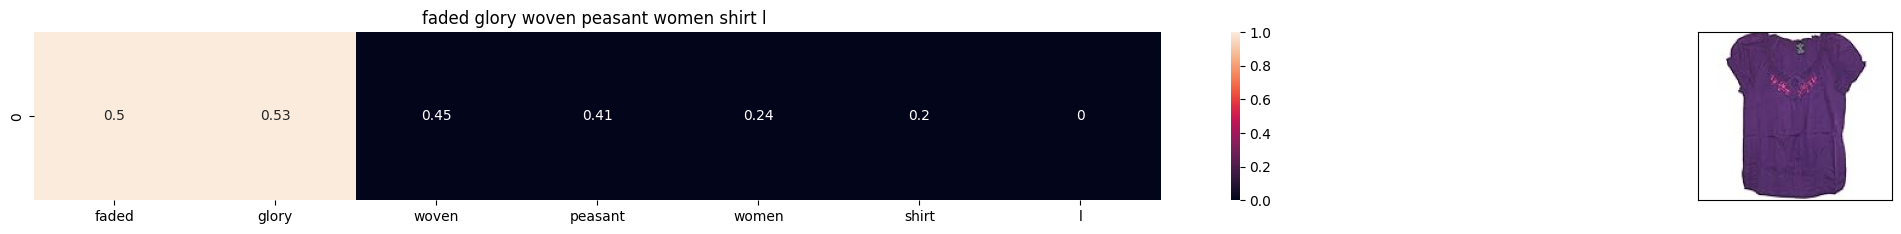

ASIN : B00LMK7YMY
Brand: Faded Glory
Title: faded glory woven peasant women shirt l 
Cosine similarity with the queried item: 0.9349978507673099


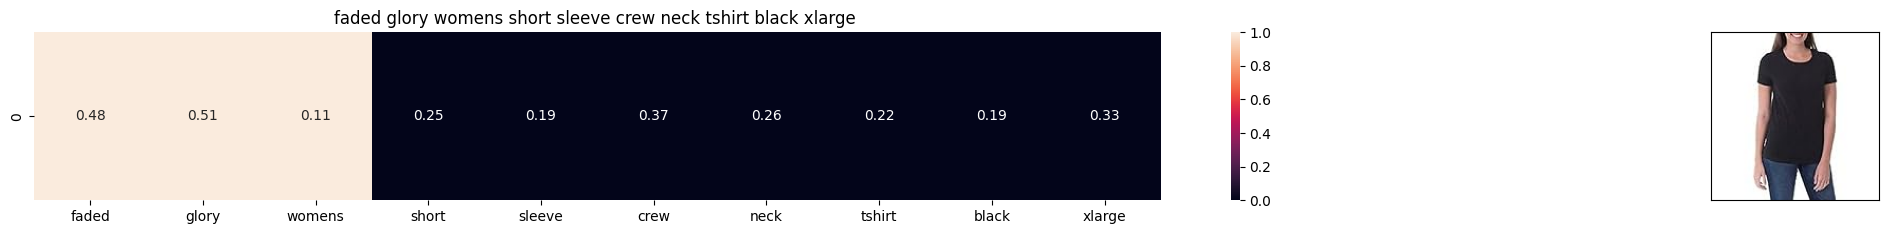

ASIN : B06XHHTDRX
Brand: Faded Glory
Title: faded glory womens short sleeve crew neck tshirt black xlarge 
Cosine similarity with the queried item: 0.9413885918487476


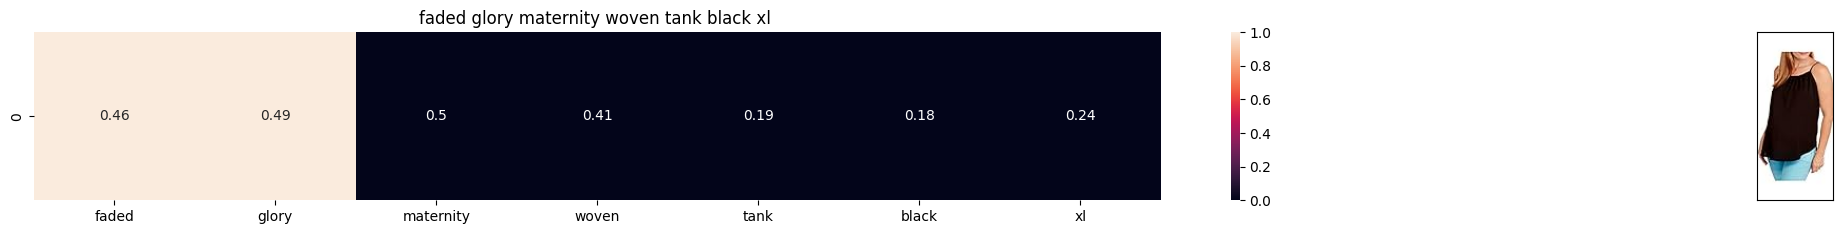

ASIN : B072Q787K6
Brand: Faded Glory
Title: faded glory maternity woven tank black xl 
Cosine similarity with the queried item: 0.980054173321325


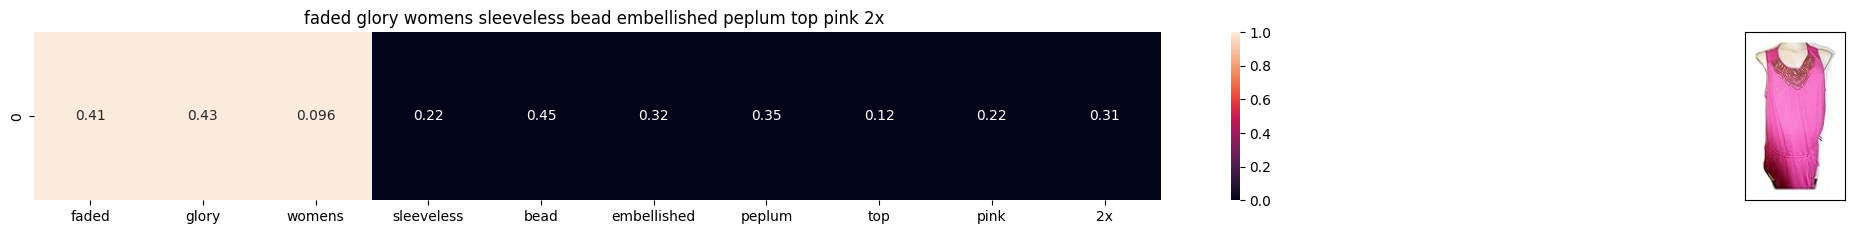

ASIN : B06XFXTC6B
Brand: Faded Glory
Title: faded glory womens sleeveless bead embellished peplum top pink 2x 
Cosine similarity with the queried item: 1.027625823376321


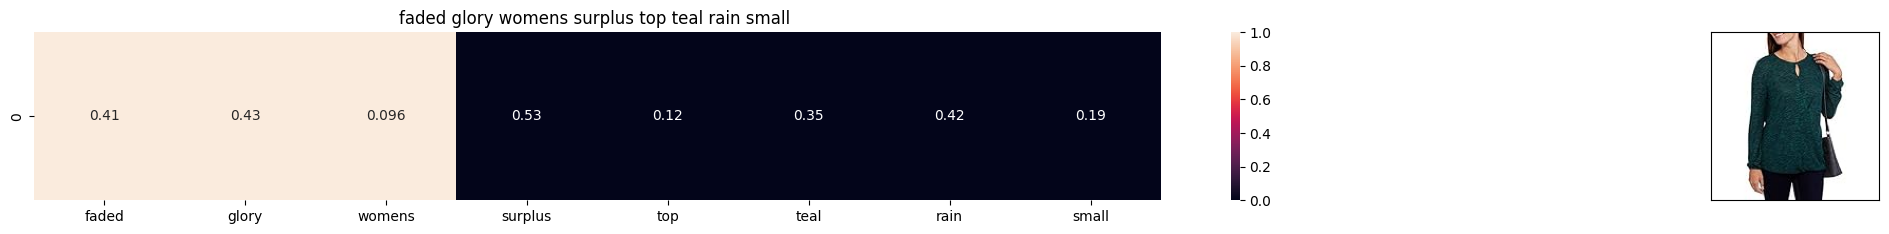

ASIN : B06XF7PVKN
Brand: Faded Glory
Title: faded glory womens surplus top teal rain small 
Cosine similarity with the queried item: 1.029753832737218


In [ ]:
tfidf_model(11566, 10)